In [10]:
import numpy as np
from math import acos, tan, radians
import cmasher as cmr
import matplotlib.cm as cm
import matplotlib.pyplot as plt  # Added for plotting
from scipy.spatial import KDTree # Added for inverse lookup

In [39]:
def load_ss433_params(source='gies'):
    """
    Load SS433 ephemeris parameters from either
    'eikenberry' or 'gies'. Returns a dict.
    """
    if source.lower() == 'eikenberry':
        jd0_precession = 2443562.23
        precession_period = 162.375
        beta = 0.2647
        theta = radians(20.92)
        inclination = radians(78.05)
        phase0 = acos(-1.0 / tan(inclination) / tan(theta))
        print("Loaded Eikenberry ephemeris parameters.")
        return {
            'jd0_precession': jd0_precession,
            'precession_period': precession_period,
            'beta': beta,
            'theta': theta,
            'inclination': inclination,
            'phase0': phase0,
            # Add Gies defaults if needed for compatibility
            'phi0': radians(-49.0), 'jd0_orb': 2450023.62, 'orbital_period': 13.08211,
            'jd0_nut': 2450000.94, 'nut_period': 6.2877, 'nut_ampl': 0.009,
            'beta_orb_ampl': 0.0066, 'beta_orb_phase0': 4.7, 'prec_pa': radians(10.0)
        }
    else:
        jd0_precession = 2451458.12
        precession_period = 162.15
        beta = 0.2602
        theta = radians(19.85)
        inclination = radians(78.83)
        phase0 = 0.0
        phi0 = radians(-49.0)
        gamma = 1.0 / np.sqrt(1 - beta**2)
        jd0_orb = 2450023.62
        orbital_period = 13.08211
        jd0_nut = 2450000.94
        nut_period = 6.2877
        nut_ampl = 0 #0.009
        beta_orb_ampl = 0 #0.0066
        beta_orb_phase0 = 4.7
        prec_pa = radians(10.0)
        print("Loaded Gies et al. ephemeris parameters.")
        return {
            'jd0_precession': jd0_precession,
            'precession_period': precession_period,
            'beta': beta,
            'theta': theta,
            'inclination': inclination,
            'phase0': phase0,
            'phi0': phi0,
            'gamma': gamma,
            'jd0_orb': jd0_orb,
            'orbital_period': orbital_period,
            'jd0_nut': jd0_nut,
            'nut_period': nut_period,
            'nut_ampl': nut_ampl,
            'beta_orb_ampl': beta_orb_ampl,
            'beta_orb_phase0': beta_orb_phase0,
            'prec_pa': prec_pa
        }

In [40]:
def ss433_phases(jd_obs, params):
    """
    Compute SS433 observables for array jd_obs.
    Returns a tuple of NumPy arrays:
      (prec_phase, prec_angle, zr, zb, orb_phase,
       mu_blue_ra, mu_blue_dec, mu_red_ra, mu_red_dec,
       pa_blue, pa_red)
    """
    jd0_p, P_p = params['jd0_precession'], params['precession_period']
    beta, theta = params['beta'], params['theta']
    inc, phi0  = params['inclination'], params['phi0']
    jd0_o, P_o = params['jd0_orb'], params['orbital_period']
    jd0_n, P_n = params['jd0_nut'], params['nut_period']
    A_n, A_bo, phi_bo0 = params['nut_ampl'], params['beta_orb_ampl'], params['beta_orb_phase0']
    chi = params['prec_pa']
    twopi = 2*np.pi

    orb_phase = ((jd_obs - jd0_o)/P_o) % 1.0
    beta_orb_phase = twopi*orb_phase + phi_bo0
    beta_orb      = beta + A_bo * np.cos(beta_orb_phase)
    gamma         = 1.0/np.sqrt(1 - beta_orb**2)

    prec_phase = (((jd_obs - jd0_p)/P_p) + params['phase0']/twopi) % 1.0
    phi_prec    = -prec_phase * twopi

    nphi   = 2*(beta_orb_phase - phi_prec - phi0)
    ampl_n = -A_n/(gamma * beta * np.sin(inc) * np.sin(theta))
    dtheta   = ampl_n * np.cos(nphi) * np.tan(theta)
    dphi     = ampl_n * np.sin(nphi)
    theta_n  = theta + dtheta
    phi_n    = phi_prec + dphi

    mu         = (np.sin(theta_n)*np.sin(inc)*np.cos(phi_n)
                  + np.cos(theta_n)*np.cos(inc))
    prec_angle= np.degrees(np.arccos(mu))

    psi = theta_n
    # Note: v_ra is East, v_dec is North
    v_ra  = ( np.sin(chi)*np.sin(psi)*np.sin(phi_n)
            + np.cos(chi)*np.sin(inc)*np.cos(psi)
            - np.cos(chi)*np.cos(inc)*np.sin(psi)*np.cos(phi_n) )
    v_dec = ( np.cos(chi)*np.sin(psi)*np.sin(phi_n)
            - np.sin(chi)*np.sin(inc)*np.cos(psi)
            + np.sin(chi)*np.cos(inc)*np.sin(psi)*np.cos(phi_n) )

    # Proper motions in units of c
    mu_red_ra   = -beta_orb * v_ra  / (1 + beta_orb*mu)
    mu_red_dec  = -beta_orb * v_dec / (1 + beta_orb*mu)
    mu_blue_ra  =  beta_orb * v_ra  / (1 - beta_orb*mu)
    mu_blue_dec =  beta_orb * v_dec / (1 - beta_orb*mu)

    # Position Angle (degrees, E of N)
    pa_blue = np.degrees(np.arctan2(mu_blue_ra,  mu_blue_dec))
    pa_red  = np.degrees(np.arctan2(mu_red_ra,   mu_red_dec))

    # Redshifts
    zr = gamma*(1 + beta_orb*mu) - 1
    zb = gamma*(1 - beta_orb*mu) - 1

    return (prec_phase, prec_angle, zr, zb, orb_phase,
            mu_blue_ra, mu_blue_dec, mu_red_ra, mu_red_dec,
            pa_blue, pa_red)

In [41]:
def print_all_phases(jd_tstart, jd_tstop, comment, params):
    """
    Print summary of precession, orbital, nutation phases,
    redshift slopes, and PA at start & stop dates.
    """
    # ... (code remains the same) ...
    print(f"{comment}, start JD: {jd_tstart}")
    jd0 = np.array([jd_tstart, jd_tstart + 0.1])
    p0, a0, zr0, zb0, o0, *_ , pa0_blue, pa0_red = ss433_phases(jd0, params) # Get both PAs
    nut0 = ((jd_tstart - params['jd0_nut']) % params['nut_period']) / params['nut_period']
    zr_dot0 = (zr0[1] - zr0[0]) / 0.1
    zb_dot0 = (zb0[1] - zb0[0]) / 0.1
    print(f"  Prec. phase, zr, zb  {p0[0]:.8f}, {zr0[0]:.8f}, {zb0[0]:.8f}")

    print(f"{comment}, stop  JD: {jd_tstop}")
    jd1 = np.array([jd_tstop, jd_tstop + 0.1])
    p1, a1, zr1, zb1, o1, *_ , pa1_blue, pa1_red = ss433_phases(jd1, params) # Get both PAs
    nut1 = ((jd_tstop - params['jd0_nut']) % params['nut_period']) / params['nut_period']
    zr_dot1 = (zr1[1] - zr1[0]) / 0.1
    zb_dot1 = (zb1[1] - zb1[0]) / 0.1
    print(f"  Prec. phase, zr, zb  {p1[0]:.8f}, {zr1[0]:.8f}, {zb1[0]:.8f}")
    print(f"  Orb. phase range:    {o0[0]:.8f}, {o1[0]:.8f}")
    print(f"  Nut. phase range:    {nut0:.8f}, {nut1:.8f}")
    print(f"  zr_dot range:        {zr_dot0:.8f}, {zr_dot1:.8f}")
    print(f"  zb_dot range:        {zb_dot0:.8f}, {zb_dot1:.8f}")
    print(f"  PA Blue range:       {pa0_blue[0]:.2f}, {pa1_blue[0]:.2f}") # Use blue PA
    print(f"  PA Red range:        {pa0_red[0]:.2f}, {pa1_red[0]:.2f}") # Use red PA

Loaded Gies et al. ephemeris parameters.
Simulating ejections from JD 2460523.5 to 2460823.5
Observing at JD 2460823.5


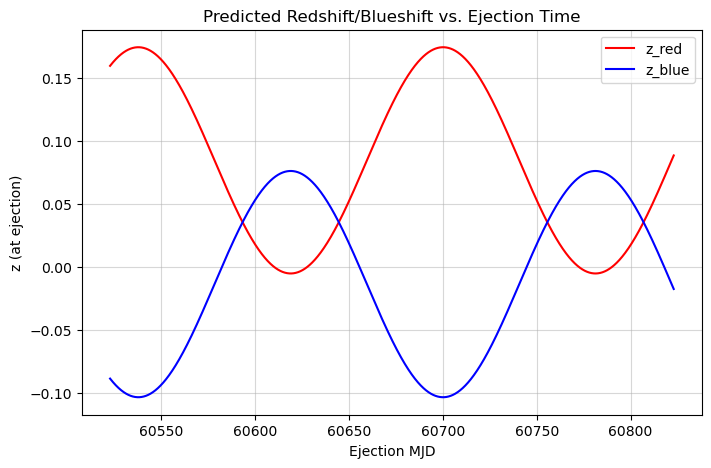

In [42]:
# --- Setup ---
params = load_ss433_params('gies')
D_kpc = 5.5  # Distance to SS433 in kpc

# Define the observation time (e.g., today or a specific HRC observation date)
jd_obs = 60823.0 + 2400000.5 # Example: May 28, 2025

# Define how far back in time we want to model ejections (e.g., 1000 days)
days_back = 300
jd_start_eject = jd_obs - days_back
jd_end_eject   = jd_obs

# Generate a dense array of ejection times
jd_eject = np.arange(jd_start_eject, jd_end_eject, 0.1) # 0.1 day steps

print(f"Simulating ejections from JD {jd_start_eject:.1f} to {jd_end_eject:.1f}")
print(f"Observing at JD {jd_obs:.1f}")

# Calculate phases & motions for all ejection times
(prec_phase, prec_angle, zr, zb, orb_phase,
 mu_blue_ra, mu_blue_dec, mu_red_ra, mu_red_dec,
 pa_blue, pa_red) = ss433_phases(jd_eject, params)

# --- Redshift Plot (Optional, but good sanity check) ---
mjd_eject = jd_eject - 2400000.5

plt.figure(figsize=(8,5))
plt.plot(mjd_eject, zr, c='r', label='z_red')
plt.plot(mjd_eject, zb, c='b', label='z_blue')
plt.xlabel('Ejection MJD')
plt.ylabel('z (at ejection)')
plt.title('Predicted Redshift/Blueshift vs. Ejection Time')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()